# Data QA Engineer Assessment - Question 2

In [17]:
# Imports

import pandas as pd
import duckdb
import matplotlib.pyplot as plt

In [18]:
# Functions

def Plot_Bar_Chat(df, x, y, title="No Title"):
   ax = df.plot.bar(x=x, y=y, title=title)
   for i, v in enumerate(df[y]):
      ax.text(i, v+0.5, str(v), ha='center')
   plt.show()

In [19]:
# Load CSV's To DataFrames

df_claims = pd.read_csv('data\\sample_claims.csv', na_filter=False).convert_dtypes(infer_objects=True)
df_codes_icd10 = pd.read_csv('data\\valid_icd_10_codes.csv', na_filter=False).astype({'code': 'string'})

#### Question 2-1 What are the top 5 most common valid diagnosis codes? (Python)

Response: Top 5 Diagnosis Codes
- 1. I10 - 126
- 2. R05 - 55
- 3. N72 - 39
- 4. C61 - 36
- 5. C20 - 29 

,diagnosis_codes,count
4,I10,126
8,R05,55
7,N72,39
2,C61,36
1,C20,29


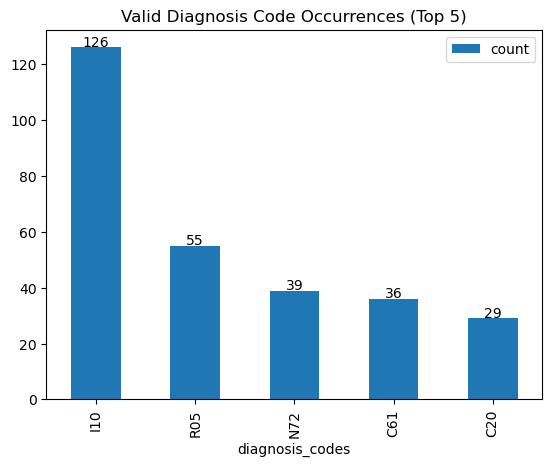

In [20]:
df_claims_explode_valid = (
      df_claims
         .assign(diagnosis_codes=df_claims['diagnosis_codes'].str.split('^'))
         .explode('diagnosis_codes')
         .merge(df_codes_icd10, left_on='diagnosis_codes', right_on='code', how='inner')
         .groupby(['diagnosis_codes'])
         .size()
         .reset_index(name='count')
         .sort_values('count', ascending=False)
         .head(5)
)

display(df_claims_explode_valid)
Plot_Bar_Chat(df_claims_explode_valid, 'diagnosis_codes', 'count', 'Valid Diagnosis Code Occurrences (Top 5)')

#### Question 2-1 What are the top 5 most common valid diagnosis codes? (SQL)

Response: Top 5 Diagnosis Codes. The SQL query used here conforms to SQL-92, with a few additional SQL extensions supported by duckDB. If necessary, I can provide another example that conforms to a different standard.
- 1. I10 - 126
- 2. R05 - 55
- 3. N72 - 39
- 4. C61 - 36
- 5. C20 - 29 

In [21]:
# Initialize DuckDB
%load_ext sql
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False
%sql duckdb:///:memory:

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [22]:
%%sql
CREATE OR REPLACE VIEW claims AS SELECT * FROM read_csv_auto('data\\sample_claims.csv', header=True);
CREATE OR REPLACE VIEW icd10 AS SELECT * FROM read_csv_auto('data\\valid_icd_10_codes.csv', header=True);

CREATE OR REPLACE VIEW valid_claims
AS SELECT 
   claims.* 
FROM
(
   SELECT  
      patient_id, 
      claim_id, 
      date_service, 
      date_received, 
      UNNEST(STRING_SPLIT(diagnosis_codes,'^')) as diagnosis_code 
   FROM claims
) AS claims
INNER JOIN icd10 
ON claims.diagnosis_code = icd10.code;

SELECT COUNT(*) AS occurrences, diagnosis_code FROM valid_claims
GROUP BY diagnosis_code
ORDER BY COUNT(*) DESC
LIMIT 5

,occurrences,diagnosis_code
0,126,I10
1,55,R05
2,39,N72
3,36,C61
4,29,J45
